## Alvan's Model: Deconvolution
$$Z=BY+(1-B)U$$
where $B,Y,U$ are independent. Then,
$$P(Z\leq z)=P(Z\leq z | B=1)P(B=1)+P(Z\leq z|B=0)P(B=0)=\frac{1}{2}\left(P(Z\leq z | B=1)+P(Z\leq z | B=0)\right)=\frac{1}{2}\left(P(Y\leq z | B=1)+P(U\leq z | B=0)\right)=\frac{1}{2}(P(Y\leq z)+P(U\leq z))$$
$$2P(Z\leq z)=P(Y\leq z)+P(U\leq z)$$
So, we have the CDF:
$$P(Y\leq y)=2P(Z\leq y)-P(U\leq y)$$
We can use the ECDF to estimate $P(Z\leq y)$ and we know $P(Y\leq y)$ for various $y$, so this gives a consistent estimator for $P(Y\leq y)$. Recall the $n$ of Alvan is $2\cdot $ the $n$ of Warner's. Similarly, we can use $f_{KDE}(z)$ to get a KDE-derived estimate for $f_{Y}(y)$. Then,
$$\hat{\theta}(y)=\frac{2}{n}\sum_{i=1}^{n}I(Z_i\leq y)-P(U\leq y)$$
$$\text{Var}(\hat{\theta}(y))=\frac{4}{n}P(Z\leq y)(1-P(Z\leq y))$$
$$\text{max}\text{Var}(\hat{\theta}(y))=\frac{4}{n}(0.5)(1-0.5)=\frac{1}{n}$$

## Setup

In [1]:
import pickle
import numpy as np
import numdifftools as nd
from matplotlib import pyplot as plt
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

import time
np.random.seed(0)

import scipy
from scipy import stats
from scipy.signal import convolve
from scipy.integrate import quad

import multiprocess as mp

import sklearn
from sklearn.linear_model import LinearRegression

/var/folders/fg/n7d57ft153bf46npr6w6jjxr0000gn/T/ipykernel_43008/3305629985.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from js import *

In [9]:
%load_ext autoreload
%autoreload 2

In [3]:
T = 2
Y = stats.norm(loc=0, scale=1)
Ys_plot = np.linspace(-3, 3, 100)
S = stats.uniform(loc=0, scale=T)
Sbnds = [0, T]
# fZA = np.vectorize(lambda z : quad(lambda t: Y.pdf(t)*S.pdf(z-t), -np.inf, z)[0])
fZA = np.vectorize(lambda z : (Y.cdf(z)-Y.cdf(z-T))/T)
dfZA = np.vectorize(lambda z : (Y.pdf(z)-Y.pdf(z-T))/T)

# fZM = np.vectorize(lambda z : quad(lambda t: Y.pdf(t)*S.pdf(z/t)/np.abs(t), -np.inf, np.inf)[0])

# assume Y symmetric about 0
fZM = np.vectorize(lambda z : quad(lambda t: Y.pdf(t)/np.abs(t), np.abs(z)/T, np.inf)[0]/T)
dfZM = np.vectorize(lambda z : -np.sign(z)*Y.pdf(np.abs(z)/T)/(T*np.abs(z)))

args = dict(r=2, n=int(1e4))

1.0000000000000013 0.25 0.28209479177387786


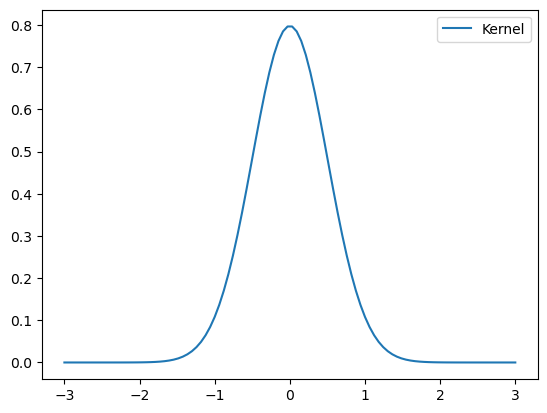

In [26]:
k = np.vectorize(lambda x:np.exp(-(x**2)/(2*.25))/(np.sqrt(2*np.pi*.25)))
# k = np.vectorize(lambda x: (np.abs(x) < 0.5)*1.)
mabg = lambda a,b,g: quad(lambda t: (t**a)*(g(t)**b), -np.inf, np.inf)[0]
rag = lambda a,g: quad(lambda t: g(t)**a, -np.inf, np.inf)[0]

print(mabg(0,1,k), mabg(2,1,k), rag(2, Y.pdf))
plt.plot(Ys_plot, k(Ys_plot), label="Kernel")
# plt.plot(Ys_plot, Y.pdf(Ys_plot), label="Y")
# plt.plot(Ys_plot, S.pdf(Ys_plot), label="S")
plt.legend()
plt.show()

In [27]:
%%time
st = time.perf_counter()
coeffJS = mabg(0,2,k)/((mabg(2,1,k)**2)*mabg(0, 2, deriv(Y.pdf,2)))
st = time.perf_counter()-st
print(st, coeffJS)
coeffM = (3*mabg(0,2,deriv(k))*mabg(2,1,lambda y: fZM(y*T)))/((mabg(2,1,k)**2)*mabg(0,2,lambda y: y*deriv(dfZM, 2)(y*T)))
st = time.perf_counter()-st
print(st, coeffM)
dbl1 = scipy.integrate.dblquad(lambda z,y: fZA(z), -np.inf, np.inf, lambda y:y, lambda y:y+T)[0] # 1.0000000005747378
st = time.perf_counter()-st
print(st)
dbl2 = scipy.integrate.dblquad(lambda z,y: deriv(dfZA,1)(z)**2, -np.inf, np.inf, lambda y:y, lambda y:y+T)[0]
st = time.perf_counter()-st
print(st)
coeffA = ((mabg(0,2,k)*dbl1)/((mabg(2,1,k)**2)*dbl2))
st = time.perf_counter()-st
print(st, coeffA)

0.581445874995552 42.666666666764925
97950.657980291 0.08810298535071988
1.8840832499990938
97992.288980875
1.8890580409934046 93.57549806464088
CPU times: user 53.2 s, sys: 1.76 s, total: 55 s
Wall time: 53.5 s


In [28]:
def hstarJS(n, r):
    return ((coeffJS*(r+1))**(1/5))/(n**(1/5))

def hstarM(n):
    return (coeffM**(1/7))/(n**(1/7))

def hstarA(n):
    return (coeffA**(1/5))/(n**(1/5))

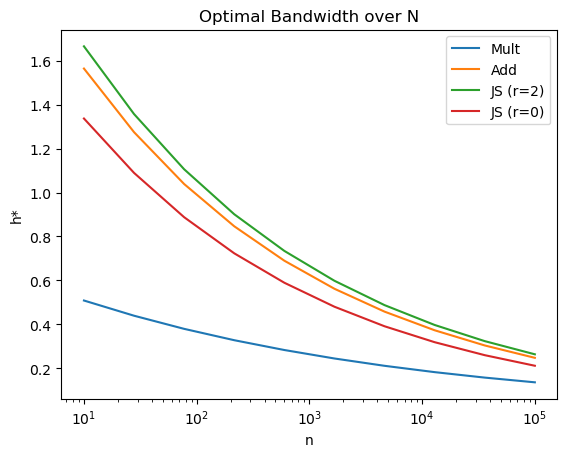

In [29]:
ns_plot = 10**np.linspace(1, 5, 10)
plt.plot(ns_plot, [hstarM(n) for n in ns_plot], label="Mult")
plt.plot(ns_plot, [hstarA(n) for n in ns_plot], label="Add")
plt.plot(ns_plot, [hstarJS(n, 2) for n in ns_plot], label="JS (r=2)")
plt.plot(ns_plot, [hstarJS(n, 0) for n in ns_plot], label="JS (r=0)")

plt.xlabel('n')
plt.xscale('log')
plt.ylabel('h*')
plt.title("Optimal Bandwidth over N")
plt.legend()
plt.show()

## Table Generation

In [31]:
%%time
B = 10
res = []
for j in [2,3,4]:
    for b in range(B):
        print(f"j: {j} b: {b}", end="\n")
        n = int(10**j)
        args = dict(r=args['r'], n=n)
        dataJS = js(Y, S, **args)
        dataM = rrtm(Y, T, n=n)
        dataA = rrta(Y, T, n=n)
        hJS, hM, hA = hstarJS(**args), hstarM(n), hstarA(n)
        print(hJS, hM, hA)
        st = time.perf_counter()
        jspdfe = jspdfest(dataJS, S, k, Sbnds=Sbnds, h=hJS, **args)(Ys_plot)
        jst = time.perf_counter() - st

        st = time.perf_counter()
        rrtpdfme = rrtpdfm(dataM, T, k, h=hM, dt=1)(Ys_plot)
        rmt = time.perf_counter() - st

        st = time.perf_counter()
        rrtpdfae = rrtpdfa(dataA, T, k, h=hA)(Ys_plot)
        rat = time.perf_counter() - st
        
        res.append([n, (jst, rmt, rat), (jspdfe, rrtpdfme, rrtpdfae), (hJS, hM, hA)])

j: 2 b: 0
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 1
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 2
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 3
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 4
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 5
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 6
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 7
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 8
1.050611121761991 0.36607501532896 0.9868074724820822
j: 2 b: 9
1.050611121761991 0.36607501532896 0.9868074724820822
j: 3 b: 0
0.6628908034683028 0.26345894377592965 0.622633422350506
j: 3 b: 1
0.6628908034683028 0.26345894377592965 0.622633422350506
j: 3 b: 2
0.6628908034683028 0.26345894377592965 0.622633422350506
j: 3 b: 3
0.6628908034683028 0.26345894377592965 0.622633422350506
j: 3 b: 4
0.6628908034683028 0.26345894377592965 0.622633422350506
j: 3 b: 5
0.6628908034683

In [32]:
def metrics(res):
    pdftrue = Y.pdf(Ys_plot)
    times = np.mean([r[1] for r in res], axis=0)
    diff = np.array([r[2] for r in res]) - np.tile(pdftrue, (B,3,1))
    bias = np.mean(diff, axis=0)
    var = np.var(diff, axis=0)
    ib = [scipy.integrate.simpson(np.abs(bi), x=Ys_plot) for bi in bias]
    ivar = [scipy.integrate.simpson(v, x=Ys_plot) for v in var]
    ise = np.array([[scipy.integrate.simpson(diff[b,i]**2, x=Ys_plot) for i in range(3)] for b in range(B)])
    mise = np.mean(ise, axis=0)
    return times, res[0][3], np.array(ib), np.array(ivar), mise

In [33]:
ind = 2
for j in range(3):
    for i in [0,2,1]:
        if i == 0: print("Joint Scrambling", end=" ")
        elif i == 2: print("\\citep{shou2023kernel}", end=" ")
        else: print("\\citep{ahmad2002kernel}", end=" ")
            
        t, h, ib, var, mise = np.array(metrics(res[j*B:(j+1)*B]))[:,i]
        print(("& $10^{:0.0f}$ & ${:0.3f}$ & ${:0.3f}$ & ${:0.3f}$ & ${:0.3f}$ & ${:0.3f}$").format(j+2, h, t, ib*100, var*100, mise*100), end="\\\\\n")
    if j < 2: print("\\"*4)
# metrics(res[B:2*B])

Joint Scrambling & $10^2$ & $1.051$ & $0.154$ & $16.016$ & $0.379$ & $0.983$\\
\citep{shou2023kernel} & $10^2$ & $0.987$ & $0.316$ & $28.486$ & $0.170$ & $2.011$\\
\citep{ahmad2002kernel} & $10^2$ & $0.366$ & $0.030$ & $31.730$ & $8.493$ & $13.609$\\
\\\\
Joint Scrambling & $10^3$ & $0.663$ & $0.631$ & $4.110$ & $0.090$ & $0.127$\\
\citep{shou2023kernel} & $10^3$ & $0.623$ & $3.944$ & $26.493$ & $0.018$ & $1.601$\\
\citep{ahmad2002kernel} & $10^3$ & $0.263$ & $0.296$ & $24.165$ & $1.176$ & $6.008$\\
\\\\
Joint Scrambling & $10^4$ & $0.418$ & $4.485$ & $2.303$ & $0.031$ & $0.045$\\
\citep{shou2023kernel} & $10^4$ & $0.393$ & $87.412$ & $25.287$ & $0.003$ & $1.452$\\
\citep{ahmad2002kernel} & $10^4$ & $0.190$ & $2.904$ & $23.111$ & $0.164$ & $5.243$\\


In [34]:
%%time
B = 10
res = []
for j in [1, 2, 3, 4]:
    for b in range(B):
        print(f"j: {j} b: {b}", end='\r')
        n = int(10**j)
        args = dict(r=args['r'], n=n)
        dataJS = js(Y, S, **args)
        dataA = rrta(Y, T, n=n)
        hA = hstarA(n)
        
        st = time.perf_counter()
        jscdfe = jscdfest(dataJS, S, **args)(Ys_plot)
        jst = time.perf_counter() - st

        st = time.perf_counter()
        rrtcdfae = rrtcdfa(dataA, T, k, h=hA)(Ys_plot)
        rat = time.perf_counter() - st
        
        res.append([n, (jst, rat), (jscdfe, rrtcdfae), (hJS, hA)])

CPU times: user 27min 17s, sys: 21.2 s, total: 27min 38s
Wall time: 27min 42s


In [35]:
def cdfmetrics(res):
    cdftrue = Y.cdf(Ys_plot)
    times = np.mean([r[1] for r in res], axis=0)
    vals = np.array([r[2] for r in res])
    diff = vals-np.tile(cdftrue, (B,2,1))
    bias = np.mean(diff, axis=0)
    var = np.var(vals, axis=0)
    ib = [scipy.integrate.simpson(bi**2, x=Ys_plot) for bi in bias]
    ivar = [scipy.integrate.simpson(v, x=Ys_plot) for v in var]
    ise = np.array([[scipy.integrate.simpson(diff[b,i]**2, x=Ys_plot) for i in range(2)] for b in range(B)])
    mise = np.mean(ise, axis=0)
    return times, res[0][3], np.array(ib), np.array(ivar), mise

In [36]:
for j in range(1,4):
    for i in [0,1]:
        if i == 0: print("Joint Scrambling", end=" ")
        elif i == 1: print("\\citep{shou2023kernel}", end=" ")
            
        t, h, ib, var, mise = np.array(cdfmetrics(res[j*B:(j+1)*B]))[:,i]
        print(("& $10^{:0.0f}$ & ${:0.3f}$ & ${:0.3f}$ & ${:0.3f}$ & ${:0.3f}$ & ${:0.3f}$").format(j+1, h, t, ib*100, var*100, mise*100), end="\\\\\n")
    if j < 4: print("\\"*4)
# metrics(res[B:2*B])

Joint Scrambling & $10^2$ & $0.418$ & $0.004$ & $0.222$ & $1.035$ & $1.258$\\
\citep{shou2023kernel} & $10^2$ & $0.987$ & $1.455$ & $1.318$ & $0.193$ & $1.511$\\
\\\\
Joint Scrambling & $10^3$ & $0.418$ & $0.004$ & $0.007$ & $0.125$ & $0.132$\\
\citep{shou2023kernel} & $10^3$ & $0.623$ & $14.747$ & $1.333$ & $0.084$ & $1.418$\\
\\\\
Joint Scrambling & $10^4$ & $0.418$ & $0.006$ & $0.001$ & $0.014$ & $0.015$\\
\citep{shou2023kernel} & $10^4$ & $0.393$ & $149.828$ & $1.208$ & $0.003$ & $1.211$\\
\\\\


## MISE Graphs

In [22]:
%%time
B = 10
nj = 10
res = []
for j in np.linspace(1,5,nj):
    for b in range(B):
        print(f"j: {j} b: {b}", end="\r")
        n = int(10**j)
        args = dict(r=args['r'], n=n)
        dataJS = js(Y, S, **args)
        hJS = hstarJS(**args)
        
        jspdfe = jspdfest(dataJS, S, Sbnds=Sbnds, k, h=hJS, **args)(Ys_plot)
        
        res.append([n, jspdfe, hJS])

/var/folders/fg/n7d57ft153bf46npr6w6jjxr0000gn/T/ipykernel_66375/2232518284.py:4: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



CPU times: user 13min 23s, sys: 11.9 s, total: 13min 35s
Wall time: 13min 42s


In [35]:
%%time
args['n'] = int(100)
B = 10
nj = 10
resR = []
for j in np.linspace(1,4,nj):
    for b in range(B):
        r = int(10**j)
        print(f"j: {j} b: {b}", end="\r")
        args = dict(r=r, n=args['n'])
        dataJS = js(Y, S, **args)
        hJS = hstarJS(**args)
        
        jspdfe = jspdfest(dataJS, S, k, Sbnds=Sbnds, h=hJS, **args)(Ys_plot)
        
        resR.append([r, jspdfe, hJS])
print()

j: 4.0 b: 96666666665 b: 9
CPU times: user 39min 24s, sys: 13.9 s, total: 39min 38s
Wall time: 3h 18min 48s


In [69]:
with open("./jspdfmiseresN.dat", "wb") as f:
    pickle.dump(res, f)

with open("./jspdfmsieresR.dat", "wb") as f:
    pickle.dump(resR, f)

In [50]:
def mise_plot(res, nj, B, ax, exp=4/5, pltmx=5, label="N"):
    ns = np.mean(np.array([r[0] for r in res]).reshape((nj,B)), axis=1)
    data = np.array([r[1] for r in res])
    ises = np.array([scipy.integrate.simpson(row, x=Ys_plot) for row in (data - np.tile(Y.pdf(Ys_plot), (B*nj,1)))**2]).reshape((nj, B))
    mise = np.mean(ises, axis=1)
    
    mean_ise = np.mean(data[:,1].reshape((nj,B)), axis=1)
    mean_ns = np.mean(data[:,0].reshape((nj,B)), axis=1)
    
    def model(n, a):
        return a*(n**(exp))
    
    popt, _ = scipy.optimize.curve_fit(model, ns, mise)
    print(f"beta = {popt}")
    
    ns_plot = 10**np.linspace(1, pltmx, 100)
    ax.plot(ns, mise, 'o-', label="Simulation")
    ax.plot(ns_plot, [model(n, *popt) for n in ns_plot], '--', label="{:0.2f}*n^(-4/5)".format(popt[0]))
    ax.set_xlabel(label)
    ax.set_xscale('log')
    # plt.yscale('log')
    ax.set_ylabel("Mean integrated square error")
    # plt.title("IMSE of PDF Estimators, Varying n")
    # plt.legend(bbox_to_anchor=(1.00, 1.00))
    # plt.show()
    # plt.savefig('../plot/jspdfmiseN.eps')

beta = [0.34176649]
beta = [0.00053077]


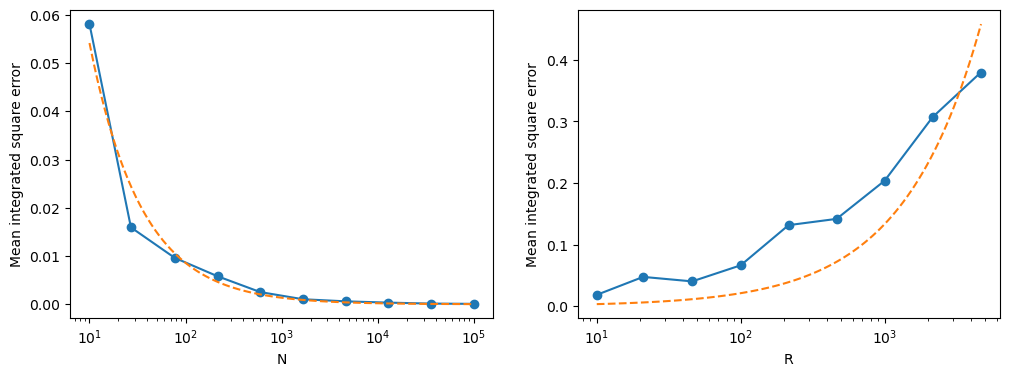

In [56]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
mise_plot(res, 10, B, axs[0], pltmx=5, exp=-4/5, label="N")
mise_plot(resR[:-10], 9, B, axs[1], pltmx=3.67, exp=4/5, label="R")
plt.savefig('../plot/jspdfmiseO.eps')

beta = [0.00022481]


Text(24.00000000000002, 0.5, 'Mean integrated square error')

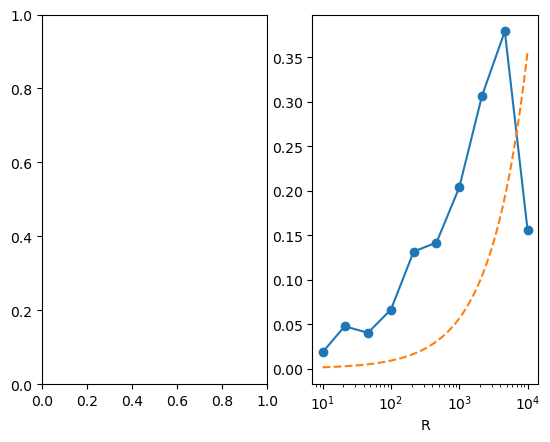

In [37]:
rs = np.mean(np.array([r[0] for r in resR]).reshape((nj,B)), axis=1)
data = np.array([r[1] for r in resR])
ises = np.array([scipy.integrate.simpson(row, x=Ys_plot) for row in (data - np.tile(Y.pdf(Ys_plot), (B*nj,1)))**2]).reshape((nj, B))
mise = np.mean(ises, axis=1)

mean_ise = np.mean(data[:,1].reshape((nj,B)), axis=1)
mean_ns = np.mean(data[:,0].reshape((nj,B)), axis=1)

def model(r, a):
    return a*(r**(4/5))

popt, _ = scipy.optimize.curve_fit(model, rs, mise)
print(f"beta = {popt}")

fig, axs = plt.subplots(1, 2)
rs_plot = 10**np.linspace(1, 4, 1000)
axs[1].plot(rs, mise, 'o-', label="Simulation")
axs[1].plot(rs_plot, [model(r, *popt) for r in rs_plot], '--', label="{:0.2f}*n^(-4/5)".format(popt[0]))
axs[1].set_xlabel("R")
axs[1].set_xscale('log')
ax.set_ylabel("Mean integrated square error")
# plt.savefig('../plot/jspdfRmme.eps')

In [ ]:
# TODO: save res, plot side by side .

## ETC

In [24]:
Ys_plot = np.linspace(-3, 3, 100)

In [25]:
%%time
n = int(1e3)
B = int(1e4)
r = 2
pool = mp.Pool(processes=mp.cpu_count())
res = np.array(pool.map(lambda _: jscdfest(js(Y, S, r, n), S, r=r, n=n)(Ys_plot), range(B)))

CPU times: user 58.5 ms, sys: 47.2 ms, total: 106 ms
Wall time: 2.96 s


Process ForkPoolWorker-92:
Process ForkPoolWorker-87:
Process ForkPoolWorker-93:
Process ForkPoolWorker-86:
Process ForkPoolWorker-88:
Process ForkPoolWorker-96:
Process ForkPoolWorker-89:
Process ForkPoolWorker-90:
Process ForkPoolWorker-85:
Process ForkPoolWorker-95:
Process ForkPoolWorker-94:
Process ForkPoolWorker-91:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/arulandu/lib/miniforge3/envs/stat/lib/python3.12/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/arulandu/lib/miniforge3/envs/stat/lib/python3.12/site-packages/multiprocess/process.py", line 314,

In [34]:
Yc, Sc = Y.cdf(Ys_plot), S.cdf(Ys_plot)
var_theo =(1/n)*(Yc*(1-Yc)+r*Sc*(1-Sc))
var_sample = np.var(res, axis=0, ddof=1)

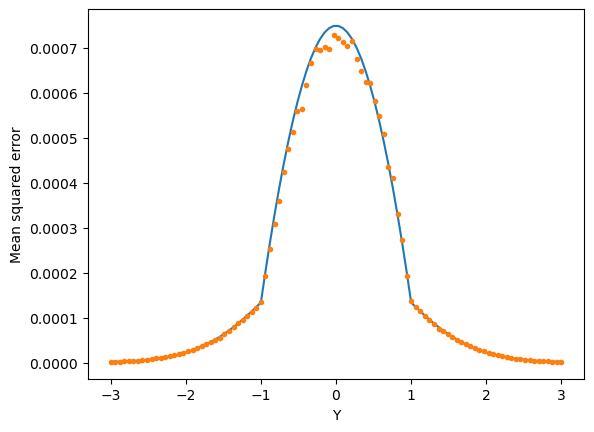

In [54]:
plt.plot(Ys_plot, var_theo, '-', label='Theoretical')
plt.plot(Ys_plot, var_sample, '.', markersize=6, label='Sample')
plt.xlabel("Y")
plt.ylabel("Mean squared error")
plt.savefig('../plot/jscdfmse.eps')
# plt.plot(Ys_plot, Yc)
# plt.legend()

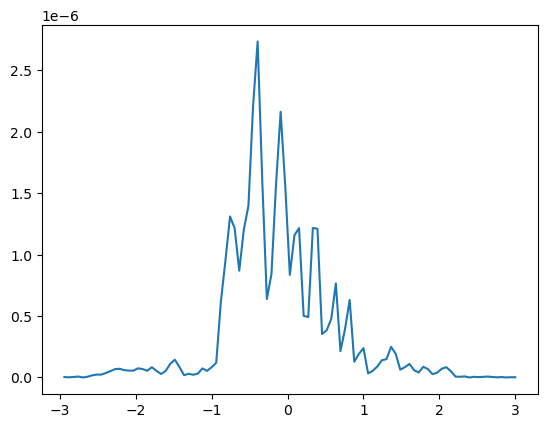

In [15]:
diff = lambda f,g: [(((f[i]+f[i-1])/2)-((g[i]+g[i-1])/2))*(Ys_plot[i]-Ys_plot[i-1]) for i in range(1,len(Ys_plot))]
plt.plot(Ys_plot[1:], np.abs(diff(var_sample, var_theo)))

In [68]:
mipe = sum(np.abs(diff(var_theo, var_sample)))/sum(diff(var_theo,np.zeros_like(var_theo)))
print("MIPE: {:.4f}%".format(mipe*100))

MIPE: 6.9625%


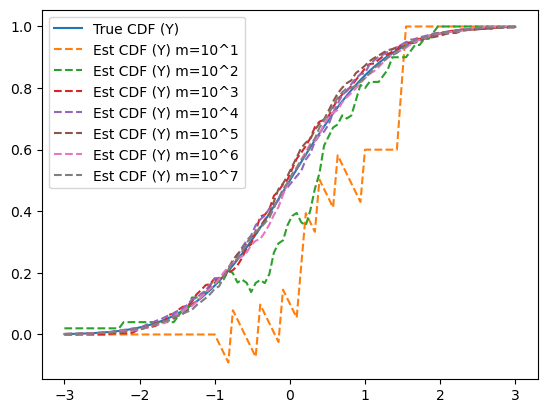

In [44]:
plt.plot(Ys_plot, Y.cdf(Ys_plot), label='True CDF (Y)', linestyle='-')

for k in range(1,8):
  est_cdfY_plot = box_sim(Y, r=1, n=int(1e3), m=int(10**k))(Ys_plot)
  plt.plot(Ys_plot, est_cdfY_plot, label=f'Est CDF (Y) m=10^{k}', linestyle='--')

plt.legend()

1
2
3
4
5
6
7


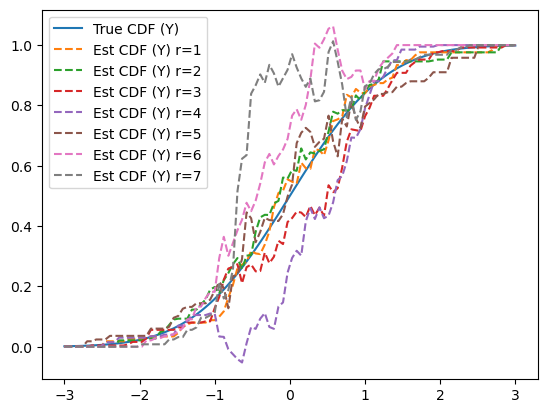

In [54]:
plt.plot(Ys_plot, Y.cdf(Ys_plot), label='True CDF (Y)', linestyle='-')

for k in range(1,8):
  est_cdfY_plot = box_sim(Y, r=k, n=int(1e2), m=int(1e3))(Ys_plot)
  plt.plot(Ys_plot, est_cdfY_plot, label=f'Est CDF (Y) r={k}', linestyle='--')

plt.legend()

In [ ]:
plt.plot(Ys_plot, Y.cdf(Ys_plot), label='True CDF (Y)', linestyle='-')

for k in range(1,7):
  est_cdfY = box_sim(Y, n=int(10**k), m=int(10**4))
  plt.plot(Ys_plot, est_cdfY(Ys_plot), label=f'Est CDF (Y) n=10^{k}', linestyle='--')

plt.legend()

In [6]:
print(mp.cpu_count())

12


In [5]:
def box_sim_mean(Y, U, r=1, n=100, m=100):  
  Ys = Y.rvs(size=n)
  Us = U.rvs(size=r*n)
  Zs = np.concatenate([Ys, Us])

  Z_sample = np.random.choice(Zs, replace=True, size=m)

  EU = quad(lambda y: (y)*U.pdf(y), -np.inf, np.inf)[0]
  est_EY = (r+1)*np.mean(Z_sample) - r*EU
  return est_EY

In [7]:
[box_sim_mean(Y, U, r=10, n=int(1e6), m=int(10**b)) for b in range(1, 7)]

[2.1711305152283686,
 0.21878136514014246,
 -0.2902443964996542,
 -0.0399498167001297,
 0.011165788771792784,
 0.003475603662873668]

In [17]:
%%time
sim = []
bs = range(1,7)
for b in bs:
    B = int(10**b)
    n = int(1e3)
    m = int(1e3)
    r = 1
    pool = mp.Pool(processes=mp.cpu_count())
    res = np.array(pool.map(lambda _: box_sim_mean(Y, U, r=r, n=n, m=m), range(B)))
    print(n, m, B, r, res.shape)
    
    EY = quad(lambda y: (y)*Y.pdf(y), -np.inf, np.inf)[0]
    E_Y2 = quad(lambda y: (y**2)*Y.pdf(y), -np.inf, np.inf)[0]
    EU = quad(lambda y: (y)*U.pdf(y), -np.inf, np.inf)[0]
    E_U2 = quad(lambda y: (y**2)*U.pdf(y), -np.inf, np.inf)[0]
    
    var_theo_EV = (1/m)*((r+1-(1/n))*(E_Y2+r*E_U2)-((1-(1/n))*(EY**2)+2*r*EY*EU+r*(r-(1/n))*(EU**2)))
    var_theo_VE = (1/n)*(E_Y2-(EY**2)+r*(E_U2-(EU**2)))
    var_theo = var_theo_EV + var_theo_VE
    
    var_sample = np.std(res, ddof=1)**2

    sim.append([var_theo, var_theo_EV, var_theo_VE, var_sample])

1000 1000 10 1 (10,)
1000 1000 100 1 (100,)
1000 1000 1000 1 (1000,)
1000 1000 10000 1 (10000,)
1000 1000 100000 1 (100000,)
1000 1000 1000000 1 (1000000,)
CPU times: user 2.01 s, sys: 310 ms, total: 2.32 s
Wall time: 3min 54s


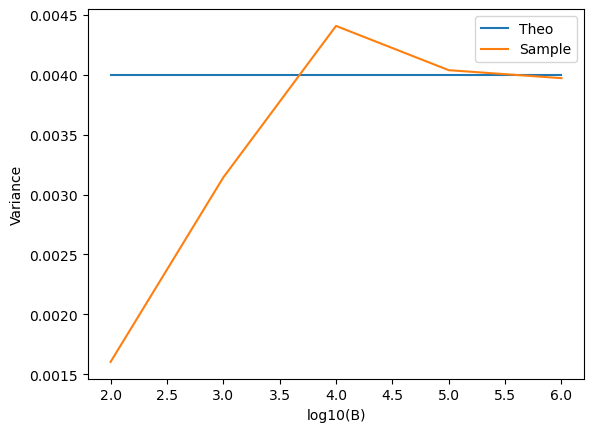

In [19]:
sim = np.array(sim)
plt.plot(bs[1:], sim[:,0][1:], label="Theo")
# plt.plot(bs, sim[:,1], label="EV")
# plt.plot(bs, sim[:,2], label="VE")
plt.plot(bs[1:], sim[:,3][1:], label="Sample")
plt.legend()
plt.xlabel("log10(B)")
plt.ylabel("Variance")
plt.show()

In [138]:
print("Sample Var: {:.8f}".format())
print("Theor  Var: {:.8f}".format(var_theo))

Sample Var: 1.27555468
Theor  Var: 1.62400000


## Privacy Regression

In [93]:
Y = stats.norm(loc=0, scale=1)
U = stats.uniform(loc=-2, scale=4)

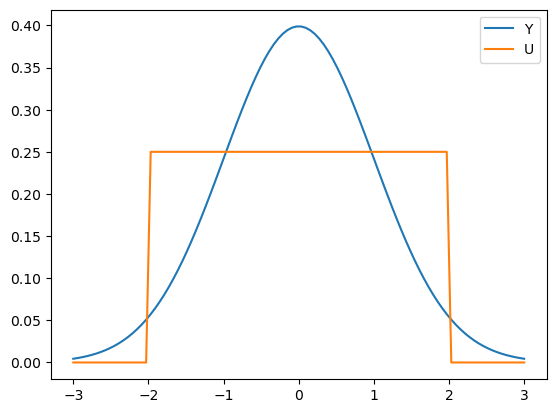

In [295]:
Ys_plot = np.linspace(-3, 3, 100)
plt.plot(Ys_plot, Y.pdf(Ys_plot), label="Y")
plt.plot(Ys_plot, U.pdf(Ys_plot), label="U")
plt.legend()

In [105]:
Ys = Y.rvs(size=n)
Us = U.rvs(size=r*n).reshape((n,r))
Xs = np.sort(np.column_stack([Ys,Us]), axis=1)

reg = model.fit(Xs, Ys)
Y_pred = model.predict(Xs)
priv = np.mean((Y_pred - Ys)**2)

/Users/arulandu/lib/miniforge3/envs/stat/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



In [106]:
model.score(Xs, Ys), np.mean((Ys-np.mean(Ys))**2)

(0.3731902212769874, 0.9731260163941612)

In [117]:
js

<function __main__.js(Y, S, r=1, n=100)>

In [13]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(max_iter=1000)
r = 2
ns = [int(1e3), int(1e6), int(1e4), int(10)]

Y, S = stats.norm(loc=0, scale=1), stats.norm(loc=0, scale=1)
Ys_train = Y.rvs(size=ns[0])
Ys_test = Y.rvs(size=ns[1])
Zs_train = np.sort(np.column_stack((Ys_train, S.rvs(size=r*ns[0]).reshape((ns[0],r)))), axis=1)
Zs_test = np.sort(np.column_stack((Ys_test, S.rvs(size=r*ns[1]).reshape((ns[1],r)))), axis=1)

reg = model.fit(Zs_train, Ys_train)

Y_test_pred = model.predict(Zs_test)

print("Siml: {:.8f}\nTheo: {:.8f}".format(model.score(Zs_train, Ys_train), 1/(r+1)))
print("Priv: {:.8f}".format(np.mean((Y_test_pred - Ys_test)**2)))

Siml: 0.36975763
Theo: 0.33333333
Priv: 0.68314737


In [202]:
Ys_plot = np.linspace(-3, 3, 100)
Y_pred_dist = np.array([model.predict(np.sort(np.column_stack((np.ones(ns[2])*y, S.rvs(size=r*ns[2]).reshape((ns[2],r)))), axis=1)) for y in Ys_plot])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


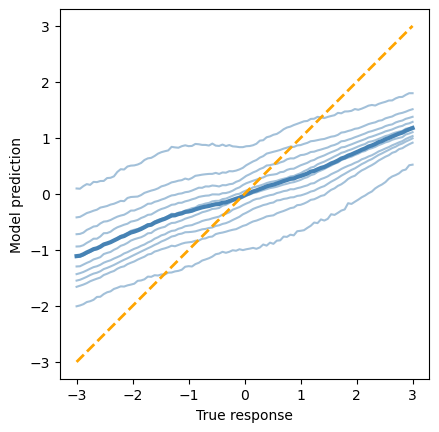

In [271]:
# plt.plot(np.tile(Ys_plot, (ns[3],1)).T.ravel(), Y_pred_dist[:,:ns[3]].ravel(), '.', alpha=0.005)

for p in np.linspace(0.025, 0.975, 10):
    plt.plot(Ys_plot, np.quantile(Y_pred_dist, p, axis=1), '-', color='steelblue', alpha=0.5, label=f'Q{p}')
# plt.plot(Ys_plot, np.quantile(Y_pred_dist, 0.025, axis=1), ':', label='Q.025')
plt.plot(Ys_plot, np.mean(Y_pred_dist,axis=1), '-', color='steelblue', label='Mean', linewidth=3)
# plt.plot(Ys_plot, np.quantile(Y_pred_dist, 0.5, axis=1), '--')
plt.plot(Ys_plot, Ys_plot, '--', color='orange', label="Ideal", linewidth=2)
plt.xlabel('True response')
plt.ylabel('Model prediction')
plt.gca().axis('scaled')
plt.savefig('../plot/mlppred.eps')
# plt.legend()

In [11]:
def privpred(Y, S, r=2, ns=(int(1e3), int(2e3)), model=LinearRegression()):
    Ys_train = Y.rvs(size=ns[0])
    Ys_test = Y.rvs(size=ns[1])
    Zs_train = np.sort(np.column_stack((Ys_train, S.rvs(size=r*ns[0]).reshape((ns[0],r)))), axis=1)
    Zs_test = np.sort(np.column_stack((Ys_test, S.rvs(size=r*ns[1]).reshape((ns[1],r)))), axis=1)
    
    reg = model.fit(Zs_train, Ys_train)
    priv = np.mean((model.predict(Zs_test) - Ys_test)**2)
    
    return model.score(Zs_train, Ys_train), priv

In [12]:
def KL(Y, U):
    def integrand(y, eps=1e-16): # D_{KL}(U || Y)
        fy, fu = Y.pdf(y), U.pdf(y)
        if np.min(np.abs([fy,fu])) < eps: return 0
        return fu*np.log(fu/fy)
    
    return quad(integrand, -np.inf, np.inf)[0]

In [278]:
Y = stats.norm(loc=0, scale=1)
ss = np.linspace(1, 8, 32)
res = []
for s in ss:
    Ss = stats.uniform(loc=-s/2, scale=s)
    kl = KL(Y, Ss)
    score, priv = np.mean([privpred(Y, Ss, r=2, ns=[int(1e3), int(1e3)], model=MLPRegressor(max_iter=1000)) for _ in range(5)], axis=0)
    print(s, kl, score, priv)
    res.append([kl, score, priv])

1.0 0.9606051998713346 0.9642955094233431 0.03463976754040994
1.2258064516129032 0.7779479719933976 0.949880403008386 0.05590335484648493
1.4516129032258065 0.6340624156634225 0.9174541067597126 0.08518526618326971
1.6774193548387095 0.5189210063565786 0.8859430041554148 0.12309269449238439
1.903225806451613 0.42631614560217723 0.8443994499641191 0.159175200142501
2.129032258064516 0.35213676049169734 0.8013018610556184 0.2074203360032964
2.354838709677419 0.2935190240251831 0.7599209495775672 0.2487579008528616
2.5806451612903225 0.24838783073312337 0.7128258874852543 0.3099435472762006
2.806451612903226 0.21519139623471908 0.6428097902388539 0.35518439032884147
3.032258064516129 0.19273882957272231 0.5916778559749613 0.4242855615059173
3.258064516129032 0.18009623798159108 0.5482120930847311 0.4651751626867823
3.4838709677419355 0.17651771558263407 0.5024027177785657 0.524275773511949
3.7096774193548385 0.18139804894170586 0.504394185914982 0.5895206757385077
3.935483870967742 0.1942

In [295]:
res = np.array(res)
klmns, pmxs = ss[np.argmin(res[:,0])], ss[np.argmax(res[:,2])]

In [84]:
res[:,2], 1-res[:,1]

(array([0.0365251 , 0.1846251 , 0.39668036, 0.61861936, 0.68304944,
        0.63011656, 0.57903844, 0.5547979 , 0.50092406, 0.48028913]),
 array([0.03637687, 0.18572011, 0.38943417, 0.62248597, 0.6705215 ,
        0.61248093, 0.58650432, 0.54711607, 0.49452065, 0.46941245]))

In [307]:
pmxs, klmns

(5.064516129032258, 3.4838709677419355)

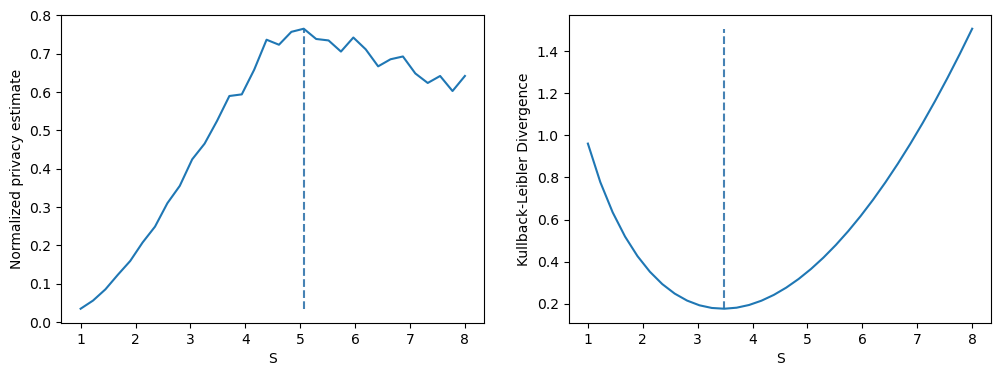

In [306]:
res = np.array(res)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot([pmxs, pmxs], [np.min(res[:,2]), np.max(res[:,2])], '--', color='steelblue')
axs[0].plot(ss, res[:,2])
axs[0].set_ylabel("Normalized privacy estimate")
axs[0].set_xlabel("S")

# axs[1].plot(ss, res[:,1])
# axs[1].set_ylabel("R^2 (MLP)")
# axs[1].set_title("R^2")

axs[1].plot([klmns, klmns], [np.min(res[:,0]), np.max(res[:,0])], '--', color='steelblue')
axs[1].plot(ss, res[:,0])
axs[1].set_ylabel("Kullback-Leibler Divergence")
axs[1].set_xlabel("S")
plt.savefig('../plot/klp.eps')

In [14]:
%%time
Y = stats.norm(loc=0, scale=1)
rs = np.arange(0, 100, 5)
B = 5
res = []
for r in rs:
    _, priv1 = np.mean([privpred(Y, stats.uniform(loc=-1, scale=1), r=r, ns=[int(1e3), int(1e3)], model=MLPRegressor(max_iter=1000)) for _ in range(B)], axis=0)
    _, priv2 = np.mean([privpred(Y, stats.norm(loc=2, scale=1), r=r, ns=[int(1e3), int(1e3)], model=MLPRegressor(max_iter=1000)) for _ in range(B)], axis=0)

    res.append([priv1, priv2])

CPU times: user 35min 12s, sys: 1min 16s, total: 36min 28s
Wall time: 4min 46s


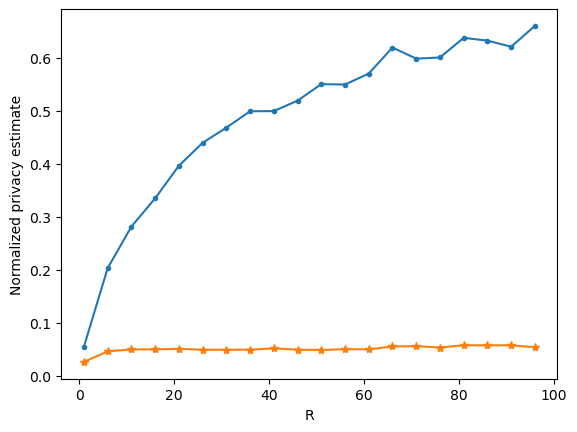

In [33]:
res = np.array(res)
# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
# axs[0].plot([pmxs, pmxs], [np.min(res[:,2]), np.max(res[:,2])], '--', color='steelblue')
plt.plot(rs, res[:,1], '-', marker='.', label='Normal')
plt.plot(rs, res[:,0], '-', marker='*', label='Uniform')
plt.ylabel("Normalized privacy estimate")
plt.xlabel("R")
plt.savefig('../plot/privr.eps')

# axs[1].plot(rs, res[:,1])
# axs[1].set_ylabel("Normalized privacy estimate")
# axs[1].set_xlabel("R")

## Binary Privacy

In [56]:
def ex(N, r, pS):
    return 0 if N < 1 else (1 if N > r else scipy.special.binom(r, N-1)*(pS**(N-1))*((1-pS)**(r-N+1)))
    
def sim(pS=.1, pY=.1, B=1000, r=1):
    res = []
    for _ in range(B):
        Ss = np.random.rand(r) < pS
        Y = int(np.random.rand() < pY)
        N = np.sum(Ss) + Y
        Ytil = ex(N, r, pS)
        res.append((Ytil - Y)**2)

    return np.mean(res)/(pY*(1-pY))

In [60]:
%%time
ps_plot = np.linspace(0, 1, 100)
py_plot = np.linspace(0.1, 0.9, 100)

ps_grid, py_grid = np.meshgrid(ps_plot, py_plot)

rhos = np.zeros(ps_grid.shape)
for i in range(ps_plot.shape[0]):
    for j in range(py_plot.shape[0]):
        rhos[j][i] = sim(pS=ps_plot[i], pY=py_plot[j], B=1000, r=2)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


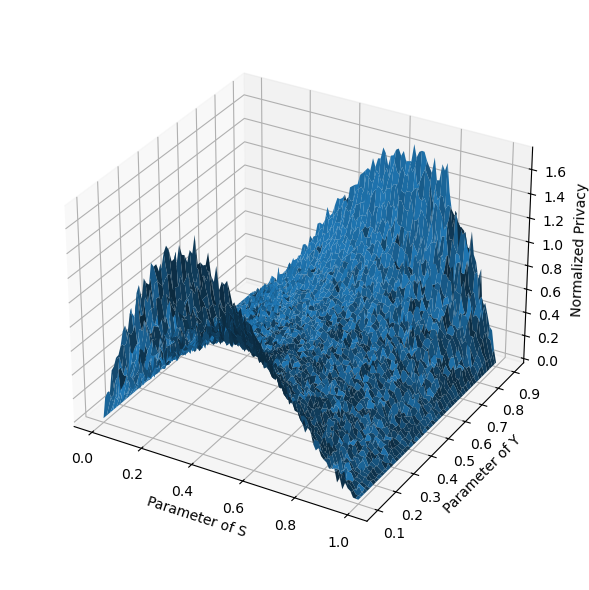

In [127]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

# ax.plot(ps_grid[:,50], py_grid, rhos[:,50], 'ro')
ax.plot_surface(ps_grid, py_grid, rhos)
ax.set_xlabel('Parameter of S')
ax.set_ylabel('Parameter of Y')
ax.set_box_aspect(None, zoom=0.915)
ax.set_zlabel('Normalized Privacy')
fig.tight_layout()
plt.savefig('../plot/jsbinrho.eps', bbox_inches='tight')

# go.Figure(data=go.Surface(x=ps_grid, y=py_grid, z=rhos))